# Differential geometry analysis on pancreatic endocrinogenesis 


In this tutorial, we will cover following topics:

- learn contionus RNA velocity vector field functions in different spaces (e.g. umap or pca space)
- rank genes based on the jacobian tensor
- build and visualize gene regulatory network with top ranked genes
- gene enrichment analyses of top ranked genes
- visualize Jacobian derived regulatory interactions across cells

In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))
# %matplotlib inline
import warnings

warnings.filterwarnings("ignore")

import dynamo as dyn


|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


Showing package dependecies which may help you debug dependency related bugs

In [2]:
dyn.get_all_dependencies_version()


package dynamo-release pre-commit colorcet cvxopt loompy matplotlib networkx  \
version          1.0.0     2.16.0    2.0.6  1.2.7  3.0.6      3.4.3    2.6.3   

package   numba numdifftools   numpy pandas pynndescent python-igraph  \
version  0.54.1       0.9.40  1.20.3  1.3.4       0.5.5         0.9.8   

package scikit-learn  scipy seaborn setuptools statsmodels    tqdm  trimap  \
version        1.0.2  1.8.0  0.11.2     58.0.4      0.13.2  4.62.3  1.0.15   

package umap-learn  
version      0.5.2

Loading `pancreatic endocrinogenesis` dataset via `dyn.sample_data`

In [3]:
dyn.configuration.set_figure_params("dynamo", background="white")
adata = dyn.sample_data.pancreatic_endocrinogenesis()


|-----> Downloading data to ./data/endocrinogenesis_day15.h5ad


Defining `pancreas_genes` list, which we will investigate in the differential geometry analysis later in this notebook.

In [4]:
pancreas_genes = [
    "Hes1",
    "Nkx6-1",
    "Nkx2-2",
    "Neurog3",
    "Neurod1",
    "Pax4",
    "Pax6",
    "Arx",
    "Pdx1",
    "Ins1",
    "Ins2",
    "Ghrl",
    "Ptf1a",
    "Iapp",
    "Isl1",
    "Sox9",
    "Gcg",
]


## Proprocessing and learn RNA velocities

Normalizing `adata` with monocle recipe, reducing its dimension via PCA and computing velocities in PCA space

In [5]:
dyn.pp.recipe_monocle(adata, n_top_genes=1000, fg_kwargs={"shared_count": 20}, genes_to_append=pancreas_genes)
dyn.tl.dynamics(adata, model="stochastic")
dyn.tl.reduceDimension(adata, n_pca_components=30)
dyn.tl.cell_velocities(adata, method="pearson", other_kernels_dict={"transform": "sqrt"})
dyn.tl.cell_velocities(adata, basis="pca")


|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----------> <insert> tkey to uns['

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [17.3505s]


estimating gamma: 100%|██████████| 1000/1000 [00:14<00:00, 67.57it/s]


|-----> retrive data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [0.0008s]
|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] finished [2.5547s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [0.6989s]
|-----> 0 genes are removed because of nan velocity values.
Using existing pearson_transition_matrix found in .obsp.
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'Size_Factor', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'highly_variable_genes', 'nCells', 'nCounts', 'pass_basic_filter', 'log_cv', 'log_m', 'score', 'frac', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_genes', 'dynamics', 'grid_velocity_umap', 'grid_velocity_pca'
    obsm: 'X_pca', 'X_umap', 'X', 'cell_cycle_scor

Visualize preprocessing results with a streamline plot on the `umap` basis.

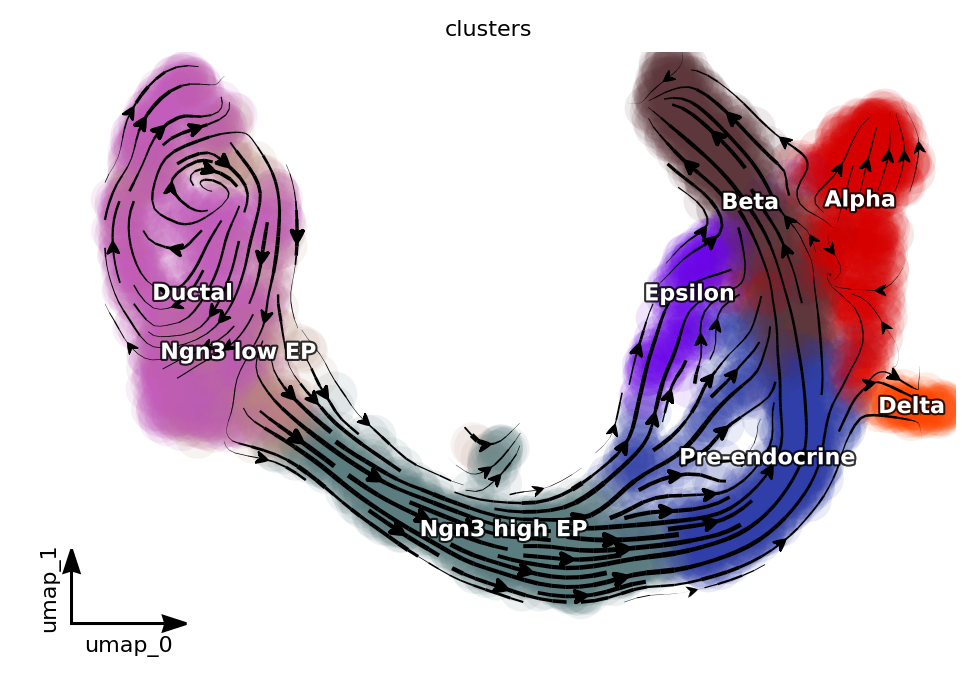

In [6]:
dyn.pl.streamline_plot(adata, color=["clusters"], basis="umap", show_legend="on data", show_arrowed_spines=True)

Visualizing cell velocity vectors via `dyn.pl.cell_wise_vectors`

|-----> X shape: (3696, 2) V shape: (3696, 2)


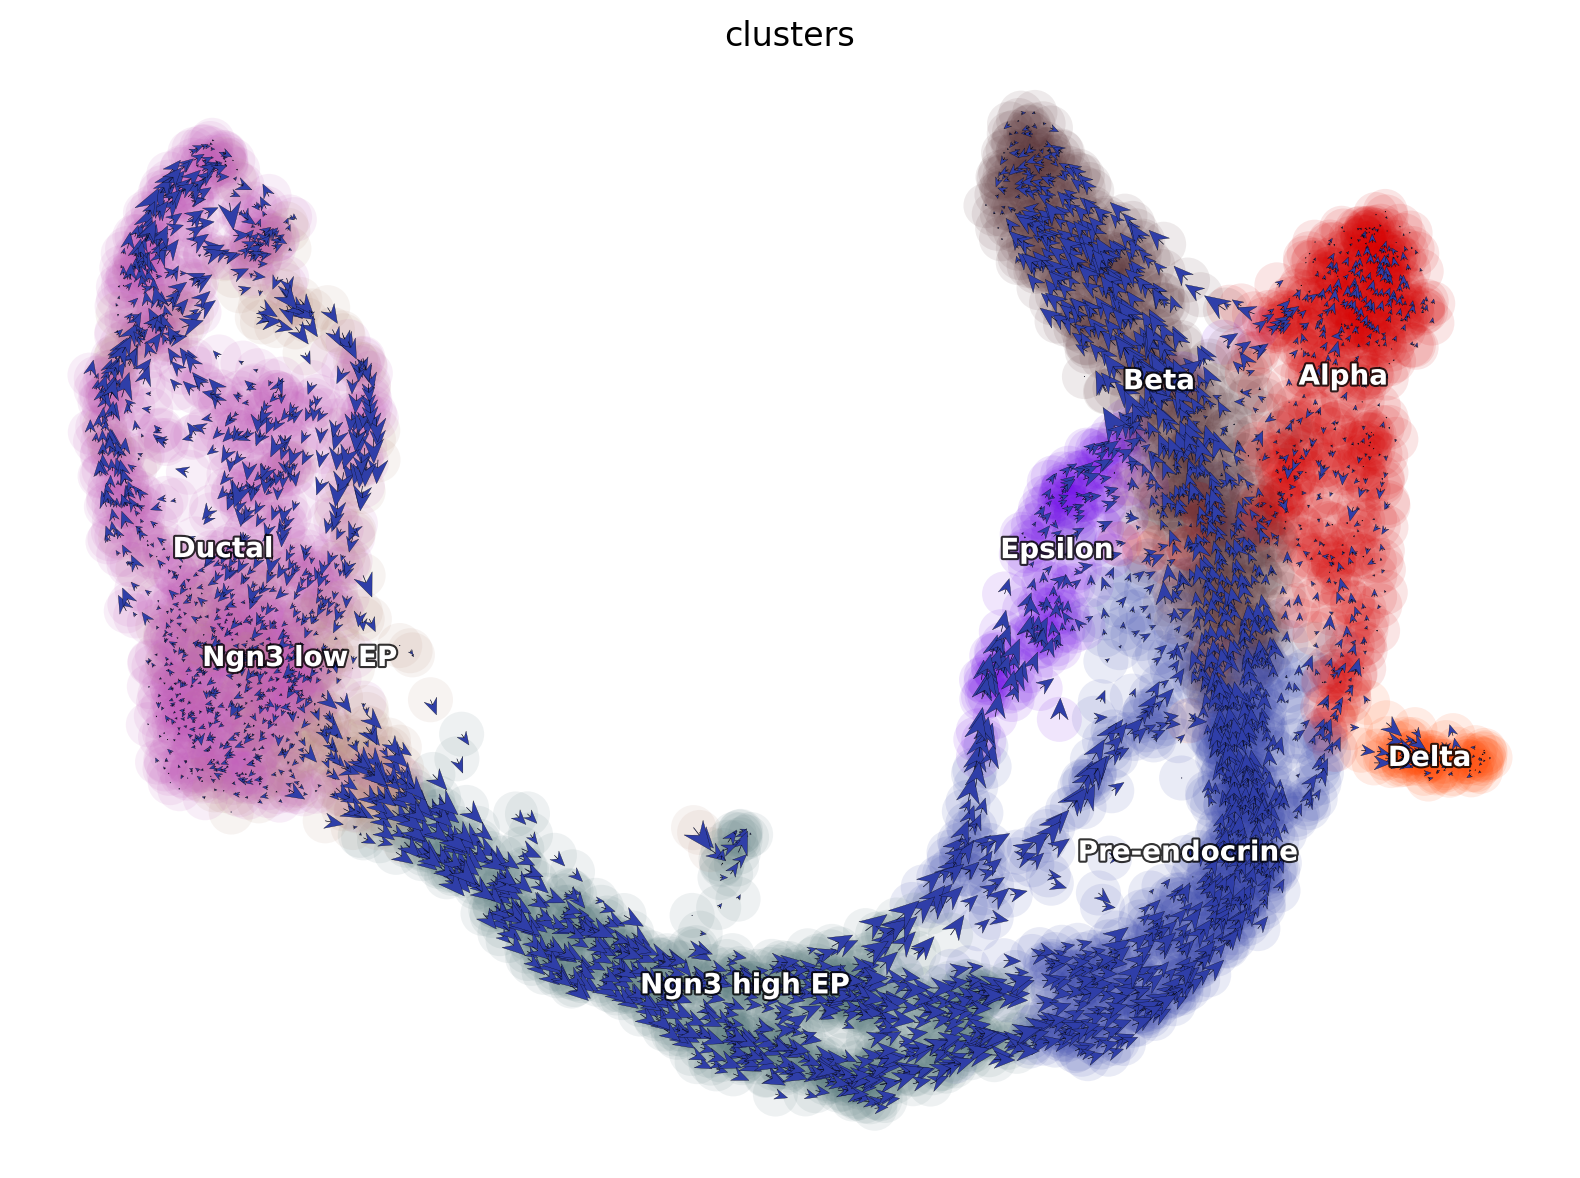

In [7]:
dyn.pl.cell_wise_vectors(
    adata,
    color=["clusters"],
    basis="umap",
    show_legend="on data",
    quiver_length=6,
    quiver_size=6,
    figsize=(8, 6),
    show_arrowed_spines=False,
)


## Differential geometry analyses reveal dynamics and key gene interactions
The diagram below illustrates the differentiation process of pancreatic endocrine cells and key regulatory genes/motifs. 

![title](images/diagram.png)

Define the `progenitor` cells: in this pancreatic endocrinogenesis dataset, we treat Doctal cells as progenitor cells.

In [8]:
progenitor = adata.obs_names[adata.obs.clusters.isin(["Ductal"])]
len(progenitor)

916

Next we show how to use `dynamo` to learn a vectorfield. Here we learn the vectorfield on the `pca` basis. The vector field can be learned on the low dimensional embedding and
            can be then projected back to the high dimensional space.   
            Since `curl` is defined in 2d/3d space, we use `umap` vectorfield to compute curl. `umap` and `pca` basis vectorfields will not interfere with each other (prefixed `pca` or `umap`) as you can check computation results in `adata`. You may try other embeddings such as PCA with fewer principe components to compute `curl`.

### Learn dynamics in PCA space via `dyn.vf.VectorField` and compute dynamics

In [9]:
# dyn.tl.cell_velocities(adata, basis="pca")
dyn.vf.VectorField(adata, basis="pca", pot_curl_div=True)
dyn.vf.VectorField(adata, basis="umap", pot_curl_div=True)

dyn.vf.speed(adata, basis="pca")
dyn.vf.divergence(adata, basis="pca")
dyn.vf.acceleration(adata, basis="pca")
dyn.vf.curl(adata, basis="umap")


|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: PCA. 
        Vector field will be learned in the PCA space.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [0.2041s]
|-----> <insert> velocity_pca_SparseVFC to obsm in AnnData Object.
|-----> <insert> X_pca_SparseVFC to obsm in AnnData Object.
|-----> <insert> VecFld_pca to uns in AnnData Object.
|-----> Running ddhodge to estimate vector field based pseudotime in pca basis...
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method

Calculating divergence: 100%|██████████| 4/4 [00:00<00:00, 12.30it/s]

|-----> <insert> control_point_pca to obs in AnnData Object.
|-----> <insert> inlier_prob_pca to obs in AnnData Object.
|-----> <insert> obs_vf_angle_pca to obs in AnnData Object.
|-----> [VectorField] in progress: 100.0000%
|-----> [VectorField] finished [19.7819s]


|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [1.0429s]
|-----> <insert> velocity_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> X_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> VecFld_umap to uns in AnnData Object.
|-----> Running ddhodge to estimate vector field based pseudotime in umap basis...
|-----> Computing curl...


Calculating 2-D curl: 100%|██████████| 3696/3696 [00:00<00:00, 28898.90it/s]

|-----> Computing divergence...



Calculating divergence: 100%|██████████| 4/4 [00:00<00:00, 34.44it/s]

|-----> <insert> control_point_umap to obs in AnnData Object.
|-----> <insert> inlier_prob_umap to obs in AnnData Object.
|-----> <insert> obs_vf_angle_umap to obs in AnnData Object.
|-----> [VectorField] in progress: 100.0000%
|-----> [VectorField] finished [21.0778s]



Calculating divergence: 100%|██████████| 4/4 [00:00<00:00, 11.77it/s]


|-----> [Calculating acceleration] in progress: 100.0000%
|-----> [Calculating acceleration] finished [0.1132s]
|-----> <insert> acceleration to layers in AnnData Object.


Calculating 2-D curl: 100%|██████████| 3696/3696 [00:00<00:00, 26807.29it/s]



The acceleration and divergence accurately highlight hotspots, including a saddle point in ductal cells (negative divergence), exit from this state to early endocrine progenitors (high positive acceleration), the bifurcation point for late progenitors to differentiate into stable cell types (high acceleration and positive divergence), and stable cell types (negative divergence).

|-----> X shape: (3696, 2) V shape: (3696, 2)


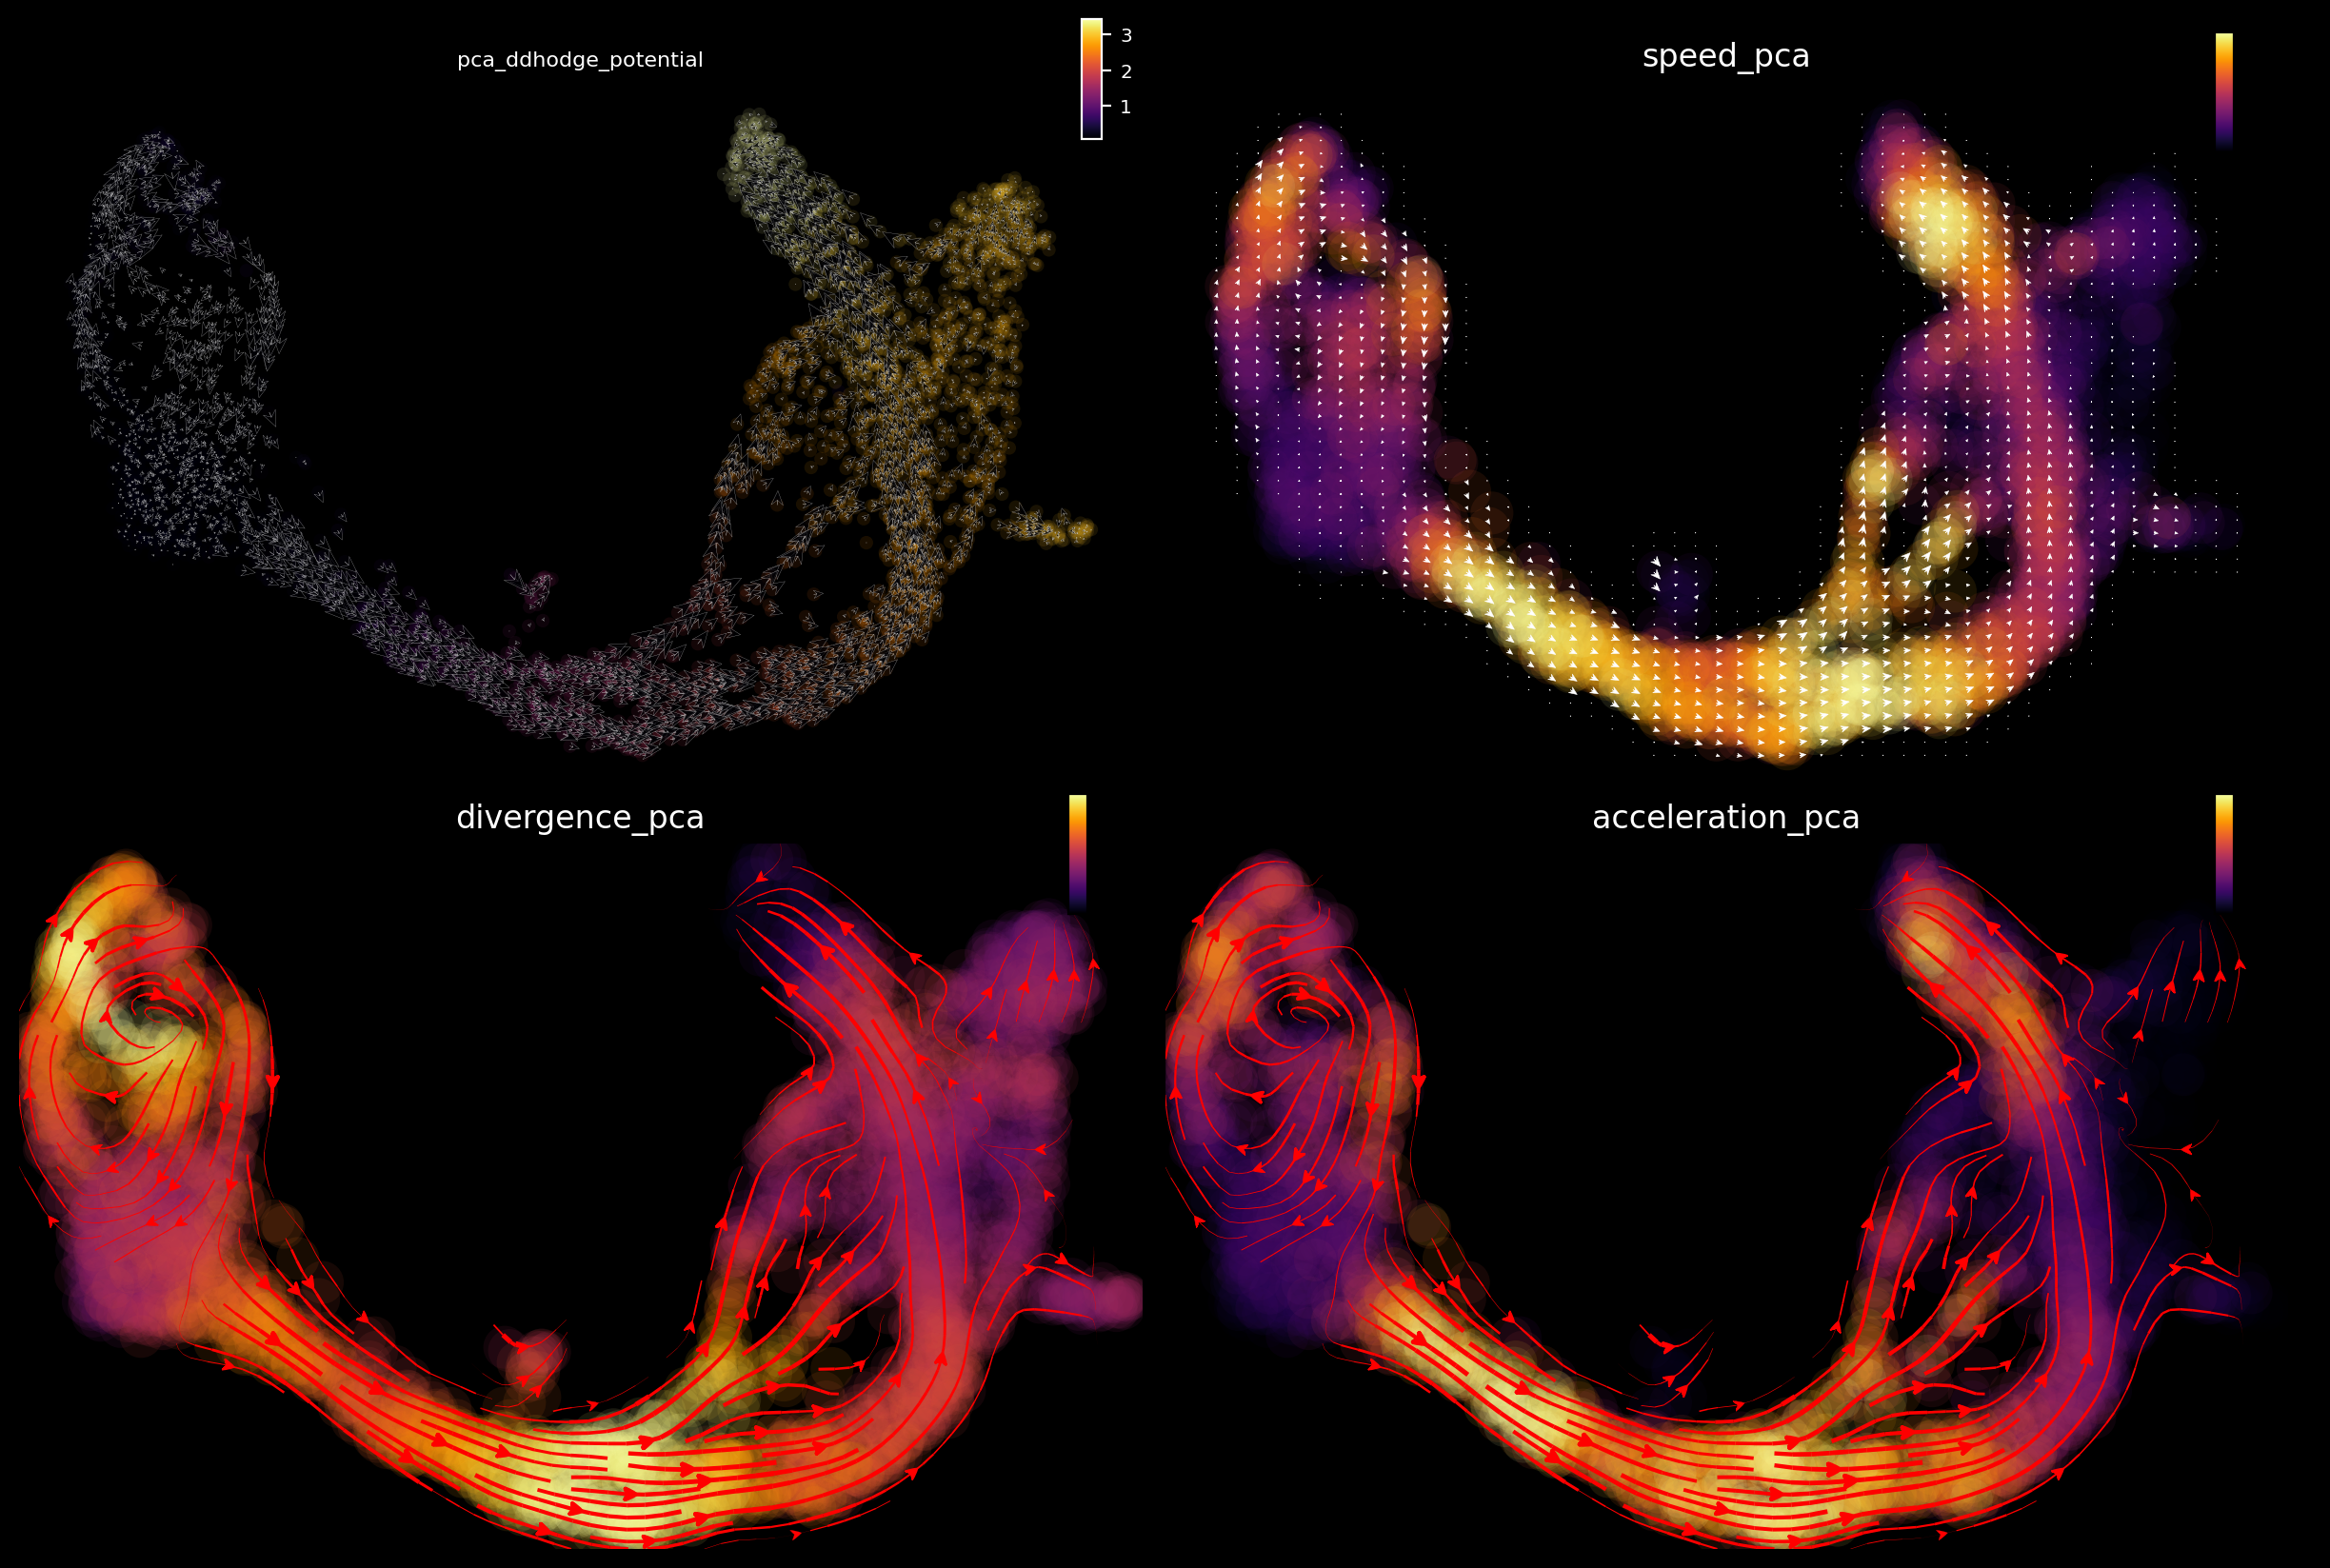

In [10]:
dyn.configuration.set_figure_params("dynamo", background="black")

import matplotlib.pyplot as plt

fig1, fig1_axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(12, 8))
dyn.pl.cell_wise_vectors(
    adata,
    color="pca_ddhodge_potential",
    pointsize=0.1,
    alpha=0.7,
    ax=fig1_axes[0, 0],
    quiver_length=6,
    quiver_size=6,
    save_show_or_return="return",
    background="black",
)
dyn.pl.grid_vectors(
    adata,
    color="speed_pca",
    basis="umap",
    ax=fig1_axes[0, 1],
    quiver_length=12,
    quiver_size=12,
    save_show_or_return="return",
    background="black",
)
dyn.pl.streamline_plot(
    adata, color="divergence_pca", basis="umap", ax=fig1_axes[1, 0], save_show_or_return="return", background="black"
)
dyn.pl.streamline_plot(
    adata, color="acceleration_pca", basis="umap", ax=fig1_axes[1, 1], save_show_or_return="return", background="black"
)
plt.show()


### Visualize vectorfield attractors and saddle points via `dyn.pl.topography`

The following 2D UMAP vector field topology shows stable fixed points (attractors) in alpha, beta, and ductal cells, and a saddle point #6 at the branching point between ductal cells and early progenitors.

|-----> Vector field for umap is but its topography is not mapped. Mapping topography now ...


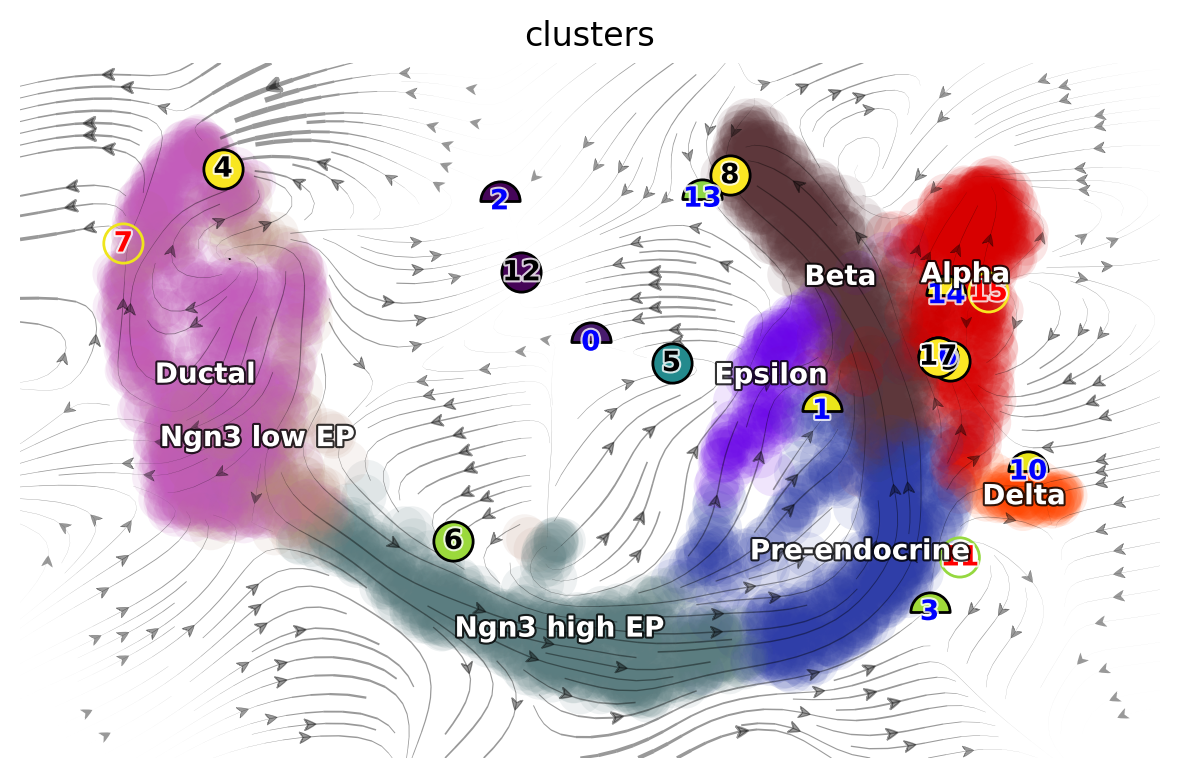

In [11]:
dyn.pl.topography(
    adata, basis="umap", background="white", color=["clusters"], streamline_color="black", show_legend="on data"
)


From the results above, we can observe that high acceleration is observed at the interface between early and late progenitors (magnitude change in velocity), and the bifurcation point where progenitors differentiate into stable cell types (direction change in velocity). Negative divergence is observed at the saddle point and attractors, and positive divergence at the bifurcation point and cell cycle of pancreatic buds. 

### Constructing a cell type state transition graph

|-----> Estimating the transition probability between cell types...
|-----> Applying vector field
|-----> [KDTree computation] in progress: 100.0000%in progress: 0.0000%
|-----> [KDTree computation] finished [0.0014s]
|-----> [iterate groups] in progress: 12.5000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 134.89it/s]


|-----> [iterate groups] in progress: 25.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 136.74it/s]


|-----> [iterate groups] in progress: 37.5000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 127.39it/s]


|-----> [iterate groups] in progress: 50.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 134.26it/s]


|-----> [iterate groups] in progress: 62.5000%

uniformly sampling points along a trajectory: 100%|██████████| 70/70 [00:00<00:00, 133.41it/s]


|-----> [iterate groups] in progress: 75.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 139.72it/s]


|-----> [iterate groups] in progress: 87.5000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 138.95it/s]


|-----> [iterate groups] in progress: 100.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 126.94it/s]


|-----> [iterate groups] in progress: 100.0000%
|-----> [iterate groups] finished [46.4732s]
|-----> [State graph estimation] in progress: 100.0000%
|-----> [State graph estimation] finished [0.0014s]


<Figure size 600x400 with 0 Axes>

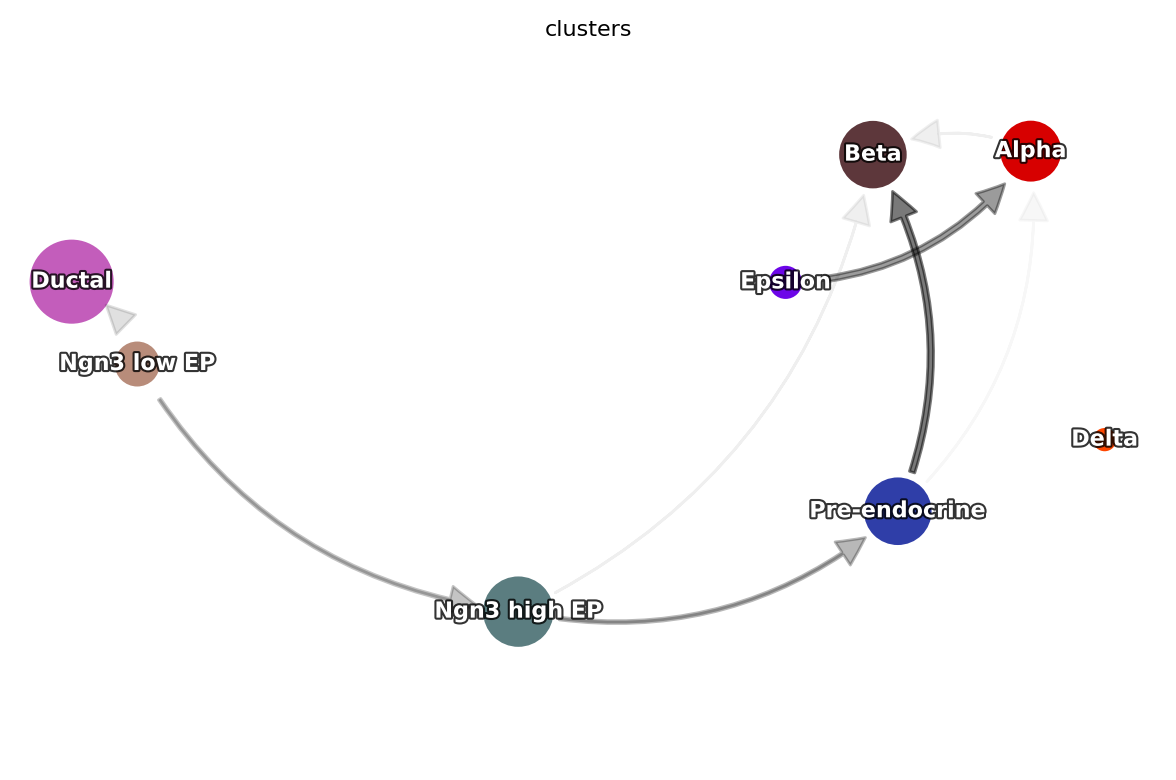

In [12]:
dyn.configuration.set_figure_params("dynamo", background="white")
dyn.pd.state_graph(adata, group='clusters', basis='pca', method='vf')
dyn.pl.state_graph(adata,
                   color=['clusters'],
                   group='clusters',
                   basis='umap',
                   show_legend='on data',
                   method='vf');

### Computing Jacobian and reveal regulator/effector gene relations via `dyn.vf.jacobian`

In [13]:
dyn.vf.jacobian(adata, regulators=pancreas_genes)

Transforming subset Jacobian: 100%|██████████| 3696/3696 [00:00<00:00, 57806.95it/s]


AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'Size_Factor', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'divergence_pca', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'control_point_umap', 'inlier_prob_umap', 'obs_vf_angle_umap', 'speed_pca', 'acceleration_pca', 'jacobian_det_pca'
    var: 'highly_variable_genes', 'nCells', 'nCounts', 'pass_basic_filter', 'log_cv', 'log_m', 'score', 'frac', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition

#### Pax4/Neurog3
Ngn3 activates Pax4 in progenitors, initiating pancreatic endocrinogenesis

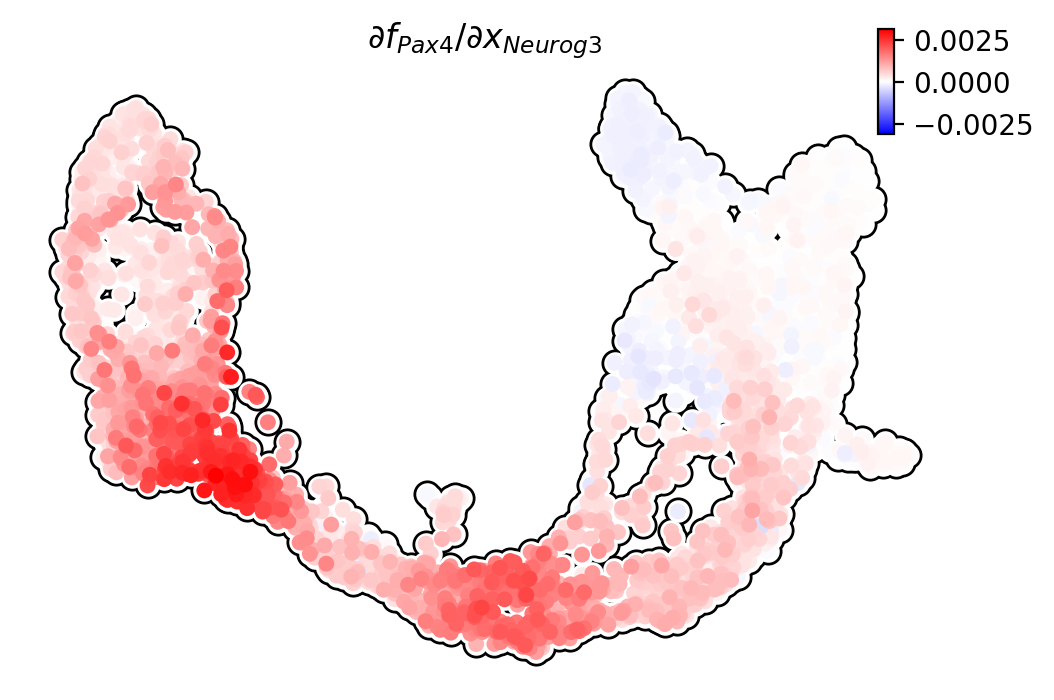

In [14]:
dyn.pl.jacobian(
    adata,
    basis="umap",
    regulators=[
        "Neurog3",
    ],
    effectors=["Pax4"],
    alpha=1,
)


#### Pax4/Arx

Jacobian analyses reveal mutual inhibition of Pax4 and Arx at the bifurcation point in progenitors. 

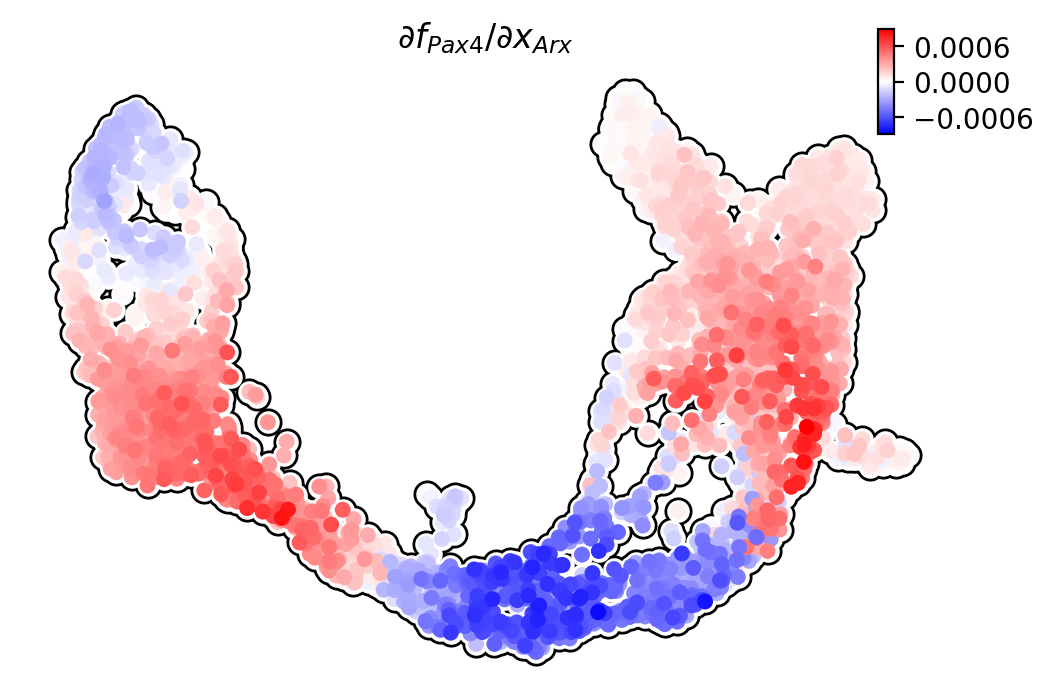

In [15]:
dyn.pl.jacobian(adata, basis="umap", regulators=["Arx"], effectors=["Pax4"], alpha=1)


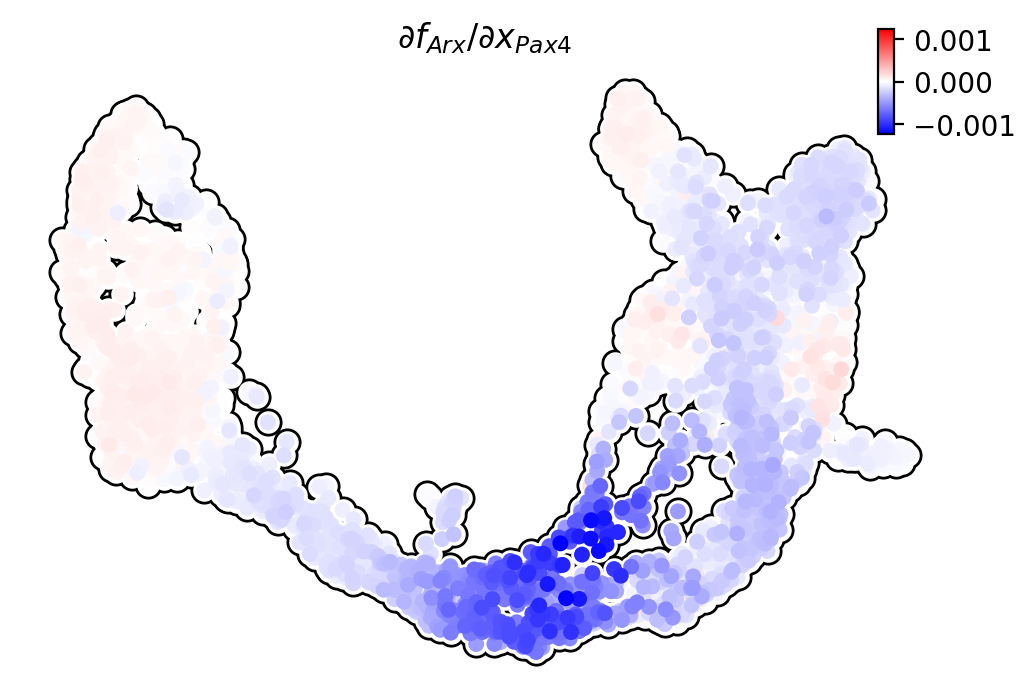

In [16]:
dyn.pl.jacobian(adata, basis="umap", regulators=["Pax4"], effectors=["Arx"], alpha=1)


#### Pax4/Ins2
Pdx1 activates Ins2 in beta cells.

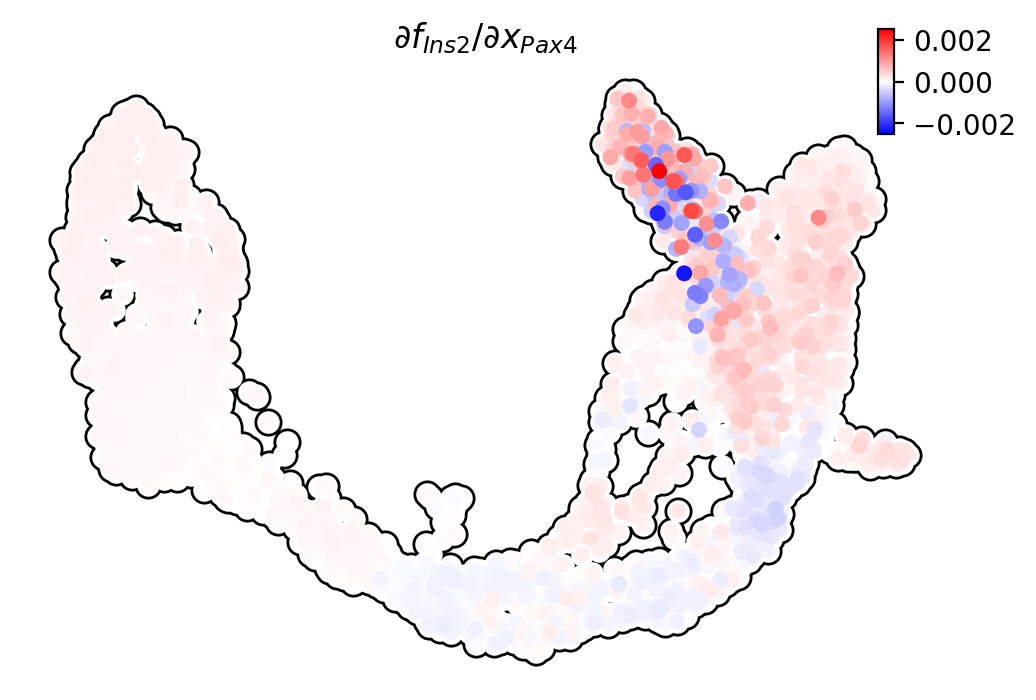

In [17]:
dyn.pl.jacobian(adata, basis="umap", regulators=["Pax4"], effectors=["Ins2"], alpha=1)


In [18]:
adata.obs["clusters"].unique()


['Pre-endocrine', 'Ductal', 'Alpha', 'Ngn3 high EP', 'Delta', 'Beta', 'Ngn3 low EP', 'Epsilon']
Categories (8, object): ['Ductal', 'Ngn3 low EP', 'Ngn3 high EP', 'Pre-endocrine', 'Beta', 'Alpha', 'Delta', 'Epsilon']

We can rank the elements in the Jacobian. There are 5 ways to rank the Jacobian:

(1) `'full_reg'`: top regulators are ranked for each effector for each cell group;

(2) `'full_eff'`: top effectors are ranked for each regulator for each cell group;

(3) '`reg`': top regulators in each cell group;

(4) '`eff`': top effectors in each cell group;

(5) '`int`': top effector-regulator pairs in each cell group.


The default mdoe is `'full_reg'`. Note that in `full_reg` and `full_eff` modes, a dictionary mapping clusters (cell type) to ranking dataframes is returned by `dyn.vf.rank_jacobian_genes`.

In [19]:
full_reg_rank = dyn.vf.rank_jacobian_genes(
    adata, groups="clusters", mode="full_reg", abs=True, output_values=True, return_df=True
)
full_eff_rank = dyn.vf.rank_jacobian_genes(
    adata, groups="clusters", mode="full_eff", abs=True, exclude_diagonal=True, output_values=True, return_df=True
)


In [32]:
full_reg_rank['Pre-endocrine'][:5]

Neurog3  Neurog3_values  Sox9  Sox9_values    Isl1  Isl1_values     Hes1  \
0     Ghrl        0.001296   Gcg     0.000307    Ghrl     0.001171      Gcg   
1     Iapp        0.000998  Ghrl     0.000281  Nkx6-1     0.000928     Ins1   
2     Isl1        0.000766  Isl1     0.000169    Ins1     0.000747     Ghrl   
3      Gcg        0.000765  Ins1     0.000149    Isl1     0.000720     Iapp   
4  Neurog3        0.000695   Arx     0.000120    Pdx1     0.000690  Neurog3   

   Hes1_values    Ins1  Ins1_values   Gcg  Gcg_values  Neurod1  \
0     0.000139    Ghrl     0.001140   Gcg    0.001022  Neurog3   
1     0.000081    Ins1     0.000658  Ghrl    0.000743     Ins1   
2     0.000064    Ins2     0.000594  Iapp    0.000613     Isl1   
3     0.000059    Iapp     0.000532  Isl1    0.000330     Pdx1   
4     0.000058  Nkx6-1     0.000482   Arx    0.000297   Nkx6-1   

   Neurod1_values   Nkx2-2  Nkx2-2_values   Ptf1a  Ptf1a_values     Pax6  \
0        0.000123     Ghrl       0.000103  Nkx6-1      0.000026     Ghrl   
1        0.000086     Iapp       0.000101    Ghrl      0.000025     Iapp   
2        0.000084     Isl1       0.000055     Gcg      0.000023  Neurog3   
3        0.000077     Ins1       0.000043    Ins1      0.000023     Isl1   
4        0.000065  Neurog3       0.000042    Isl1      0.000022   Nkx6-1   

   Pax6_values Nkx6-1  Nkx6-1_values  Pdx1  Pdx1_values     Pax4  Pax4_values  \
0     0.000491    Gcg       0.001564   Gcg     0.001000  Neurog3     0.000412   
1     0.000404   Isl1       0.000875  Ghrl     0.000825     Isl1     0.000401   
2     0.000372    Arx       0.000597   Arx     0.000762   Nkx6-1     0.000383   
3     0.000350   Ins1       0.000487  Isl1     0.000758     Ins1     0.000378   
4     0.000271   Iapp       0.000430  Iapp     0.000757     Iapp     0.000372   

     Ghrl  Ghrl_values     Iapp  Iapp_values    Ins2  Ins2_values   Arx  \
0    Ghrl     0.002554     Iapp     0.001960    Iapp     0.001039   Gcg   
1     Gcg     0.001548     Isl1     0.001755    Ghrl     0.000729   Arx   
2    Iapp     0.001023     Ghrl     0.001590  Nkx6-1     0.000524  Isl1   
3    Ins1     0.000909     Pdx1     0.001521    Ins1     0.000457  Iapp   
4  Nkx6-1     0.000839  Neurog3     0.001257    Ins2     0.000455  Pdx1   

   Arx_values  
0    0.001190  
1    0.000636  
2    0.000594  
3    0.000539  
4    0.000532

### Arcplot shows gene regulatory networks in progenitors and beta cells
Next we use `dyn.vf.build_network_per_cluster` to build an `cluster2edges` dictionary which maps cluster name (celltype) to dataframes containing edge information that is necessary to build a `networkx` graph object. Then we can visualize regulatory networks via `dyn.pl.arcPlot`.

An example regulatory network in progenitor (Ductal) cells

|-----> [iterating reg_groups] in progress: 100.0000%
|-----> [iterating reg_groups] finished [0.1345s]


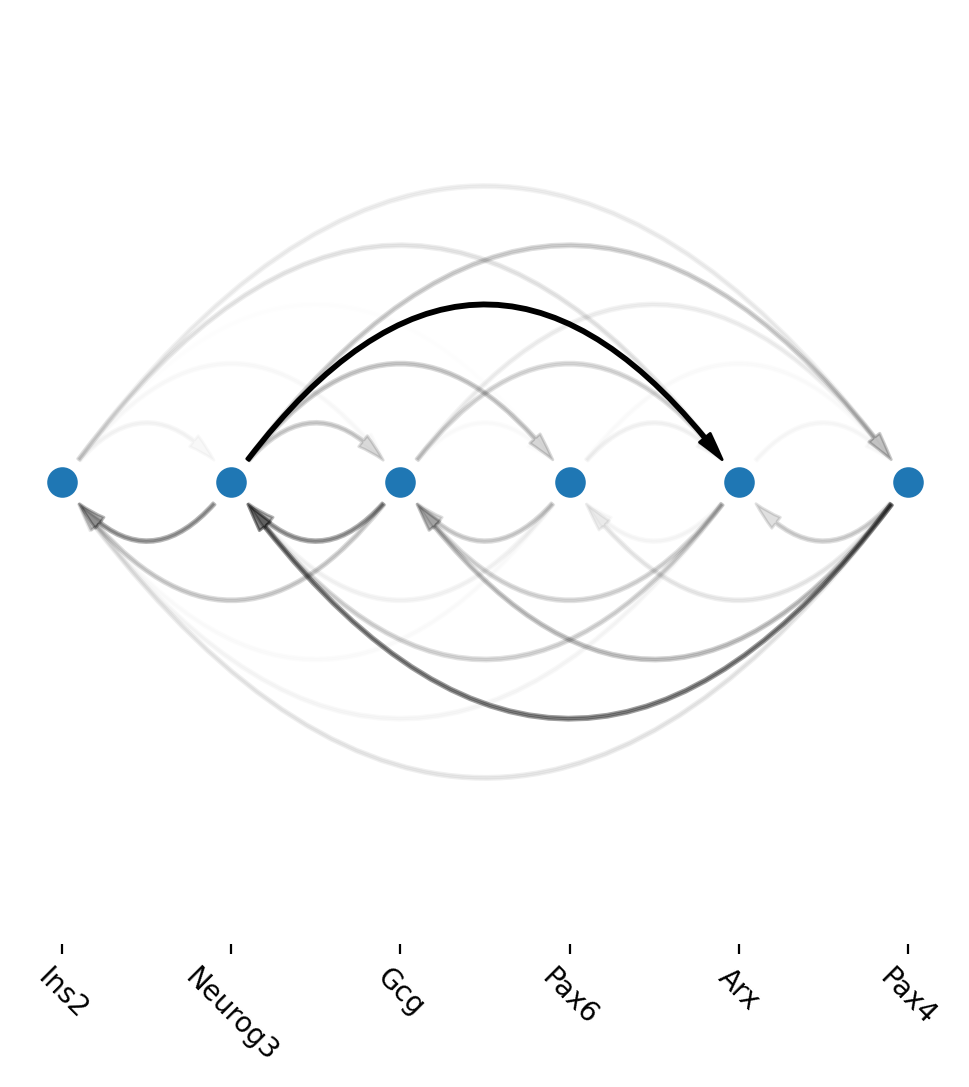

In [20]:
cell_type_regulators = ["Neurog3", "Arx", "Pax4", "Pax6", "Gcg", "Ins2", "Ss5", "Ghri"]
cluster2edges = dyn.vf.build_network_per_cluster(
    adata,
    cluster="clusters",
    cluster_names=None,
    full_reg_rank=full_reg_rank,
    full_eff_rank=full_eff_rank,
    genes=cell_type_regulators,
    n_top_genes=100,
)

import networkx as nx

network = nx.from_pandas_edgelist(
    cluster2edges["Ductal"], "regulator", "target", edge_attr="weight", create_using=nx.DiGraph()
)

ax = dyn.pl.arcPlot(
    adata, cluster="clusters", cluster_name="Beta", edges_list=None, network=network, color=None
)  # color="M_s")


Another example regulatory network in Beta cells

|-----> [iterating reg_groups] in progress: 100.0000%
|-----> [iterating reg_groups] finished [0.1135s]


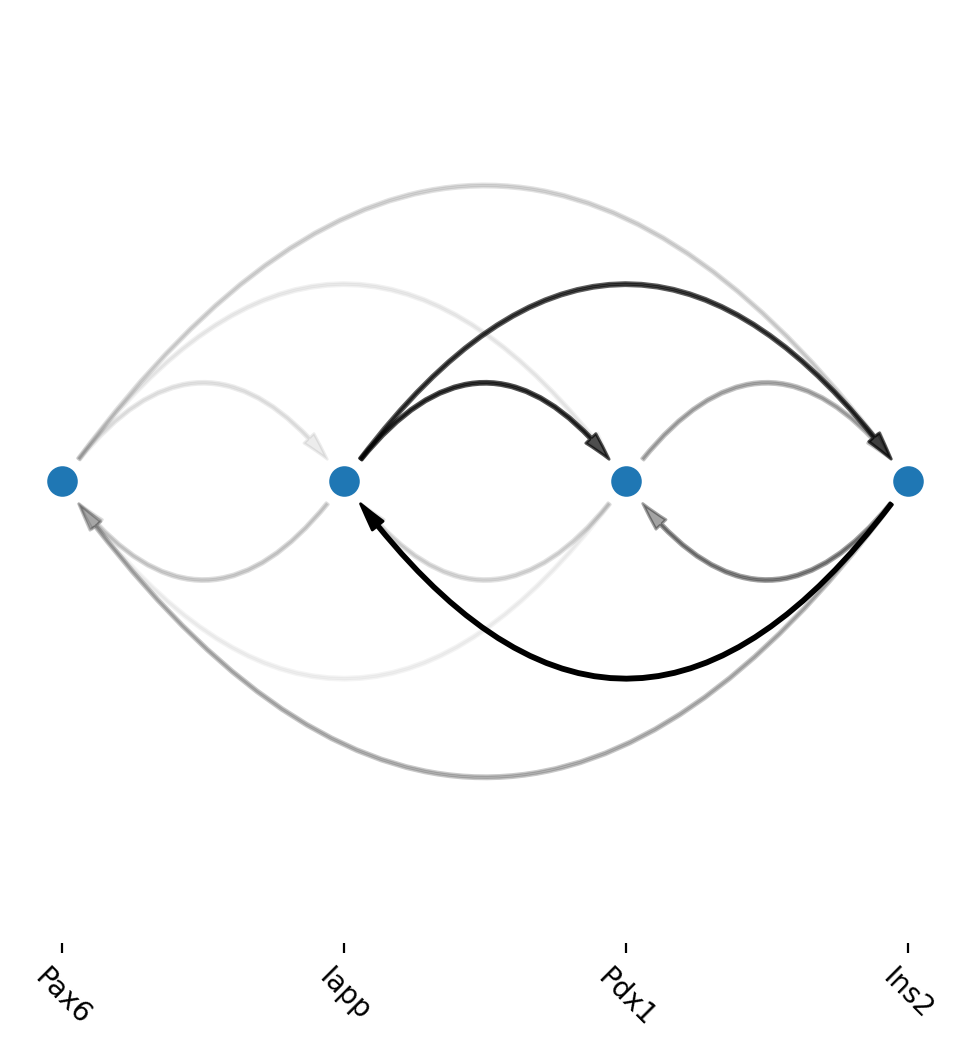

In [21]:
cell_type_regulators = ["Pax6", "Pdx1", "Iapp", "Ins2"]
cluster2edges = dyn.vf.build_network_per_cluster(
    adata,
    cluster="clusters",
    cluster_names=None,
    full_reg_rank=full_reg_rank,
    full_eff_rank=full_eff_rank,
    genes=cell_type_regulators,
    n_top_genes=100,
)

import networkx as nx

network = nx.from_pandas_edgelist(
    cluster2edges["Beta"], "regulator", "target", edge_attr="weight", create_using=nx.DiGraph()
)

ax = dyn.pl.arcPlot(
    adata, cluster="clusters", cluster_name="Beta", edges_list=None, network=network, color=None
)  # color="M_s")


### Acceleration Ranking

The acceleration can be computed based on the Jacobian. The acceleration indicates the rate of change in the velocity for a gene.

In [23]:
dyn.vf.acceleration(adata, basis='pca')
dyn.vf.rank_acceleration_genes(adata, groups='clusters')

|-----> [Calculating acceleration] in progress: 100.0000%
|-----> [Calculating acceleration] finished [0.1205s]
|-----> <insert> acceleration to layers in AnnData Object.


AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'Size_Factor', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'divergence_pca', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'control_point_umap', 'inlier_prob_umap', 'obs_vf_angle_umap', 'speed_pca', 'acceleration_pca', 'jacobian_det_pca'
    var: 'highly_variable_genes', 'nCells', 'nCounts', 'pass_basic_filter', 'log_cv', 'log_m', 'score', 'frac', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition

In [24]:
adata.uns['rank_acceleration'][:5]

Alpha  Beta   Delta     Ductal Epsilon Ngn3 high EP Ngn3 low EP  \
0       Ghrl  Ins1  Cdkn1a  Hist1h2bc     Gcg         Chga     Neurog3   
1        Cck  Ins2     Cck      Ccnb2  Tmsb4x         Chgb      Tmsb4x   
2        Mdk  Xist    Krt7      Cdc20   Rps19       Tm4sf4      Btbd17   
3       Xist  Krt7    Ins1      Hmgb2  Nkx6-1      Akr1c19         Mdk   
4  Serpina1c  Krt8    Krt8      Birc5   Rpl39         Spp1   Hist1h2bc   

  Pre-endocrine  
0          Iapp  
1        Tmsb4x  
2          Calr  
3           Pyy  
4      Ppp1r14a

### Enrichment Analysis

Enrichment analysis allows us to see if top ranking genes are significantly enriched in certain biological pathways. For example, when we pick the top 100 accelerating genes in Ductal cells, we found that they are highly enriched in cell cycle related pathways.

In [25]:
enr = dyn.ext.enrichr(adata.uns['rank_acceleration']['Ductal'][:100].to_list(), organism='mouse', outdir='./enrichr')
enr.results.head(5)

Gene_set  \
0  GO_Biological_Process_2018   
1  GO_Biological_Process_2018   
2  GO_Biological_Process_2018   
3  GO_Biological_Process_2018   
4  GO_Biological_Process_2018   

                                                Term Overlap       P-value  \
0  mitotic sister chromatid segregation (GO:0000070)   10/82  9.785475e-12   
1          mitotic spindle organization (GO:0007052)    9/74  1.142841e-10   
2  regulation of mitotic cell cycle phase transit...  12/184  1.331262e-10   
3           metaphase plate congression (GO:0051310)    7/44  2.078922e-09   
4  establishment of chromosome localization (GO:0...    5/13  3.521204e-09   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      7.975162e-09            0                     0   30.598765   
1      3.616595e-08            0                     0   30.180051   
2      3.616595e-08            0                     0   15.640592   
3      4.235804e-07            0                     0   40.407149   
4      5.739563e-07            0                     0  130.868421   

   Combined Score                                              Genes  
0      775.682435  CENPE;CCNB1;KIFC1;PRC1;NUSAP1;CDCA8;KIF23;KIF2...  
1      690.891800  CENPE;TPX2;CCNB1;KIFC1;PRC1;BIRC5;KIF23;AURKA;...  
2      355.662738  CDC20;TPX2;CENPE;CCNB1;CENPF;NDE1;CDK1;HMMR;DY...  
3      807.796133          CENPE;CCNB1;CENPF;KIFC1;CDCA8;KIF2C;KIF22  
4     2547.283519                       CENPE;CENPF;NDE1;KIF2C;KIF22

<AxesSubplot:title={'center':'KEGG_2016'}, xlabel='-log$_{10}$(Adjusted P-value)'>

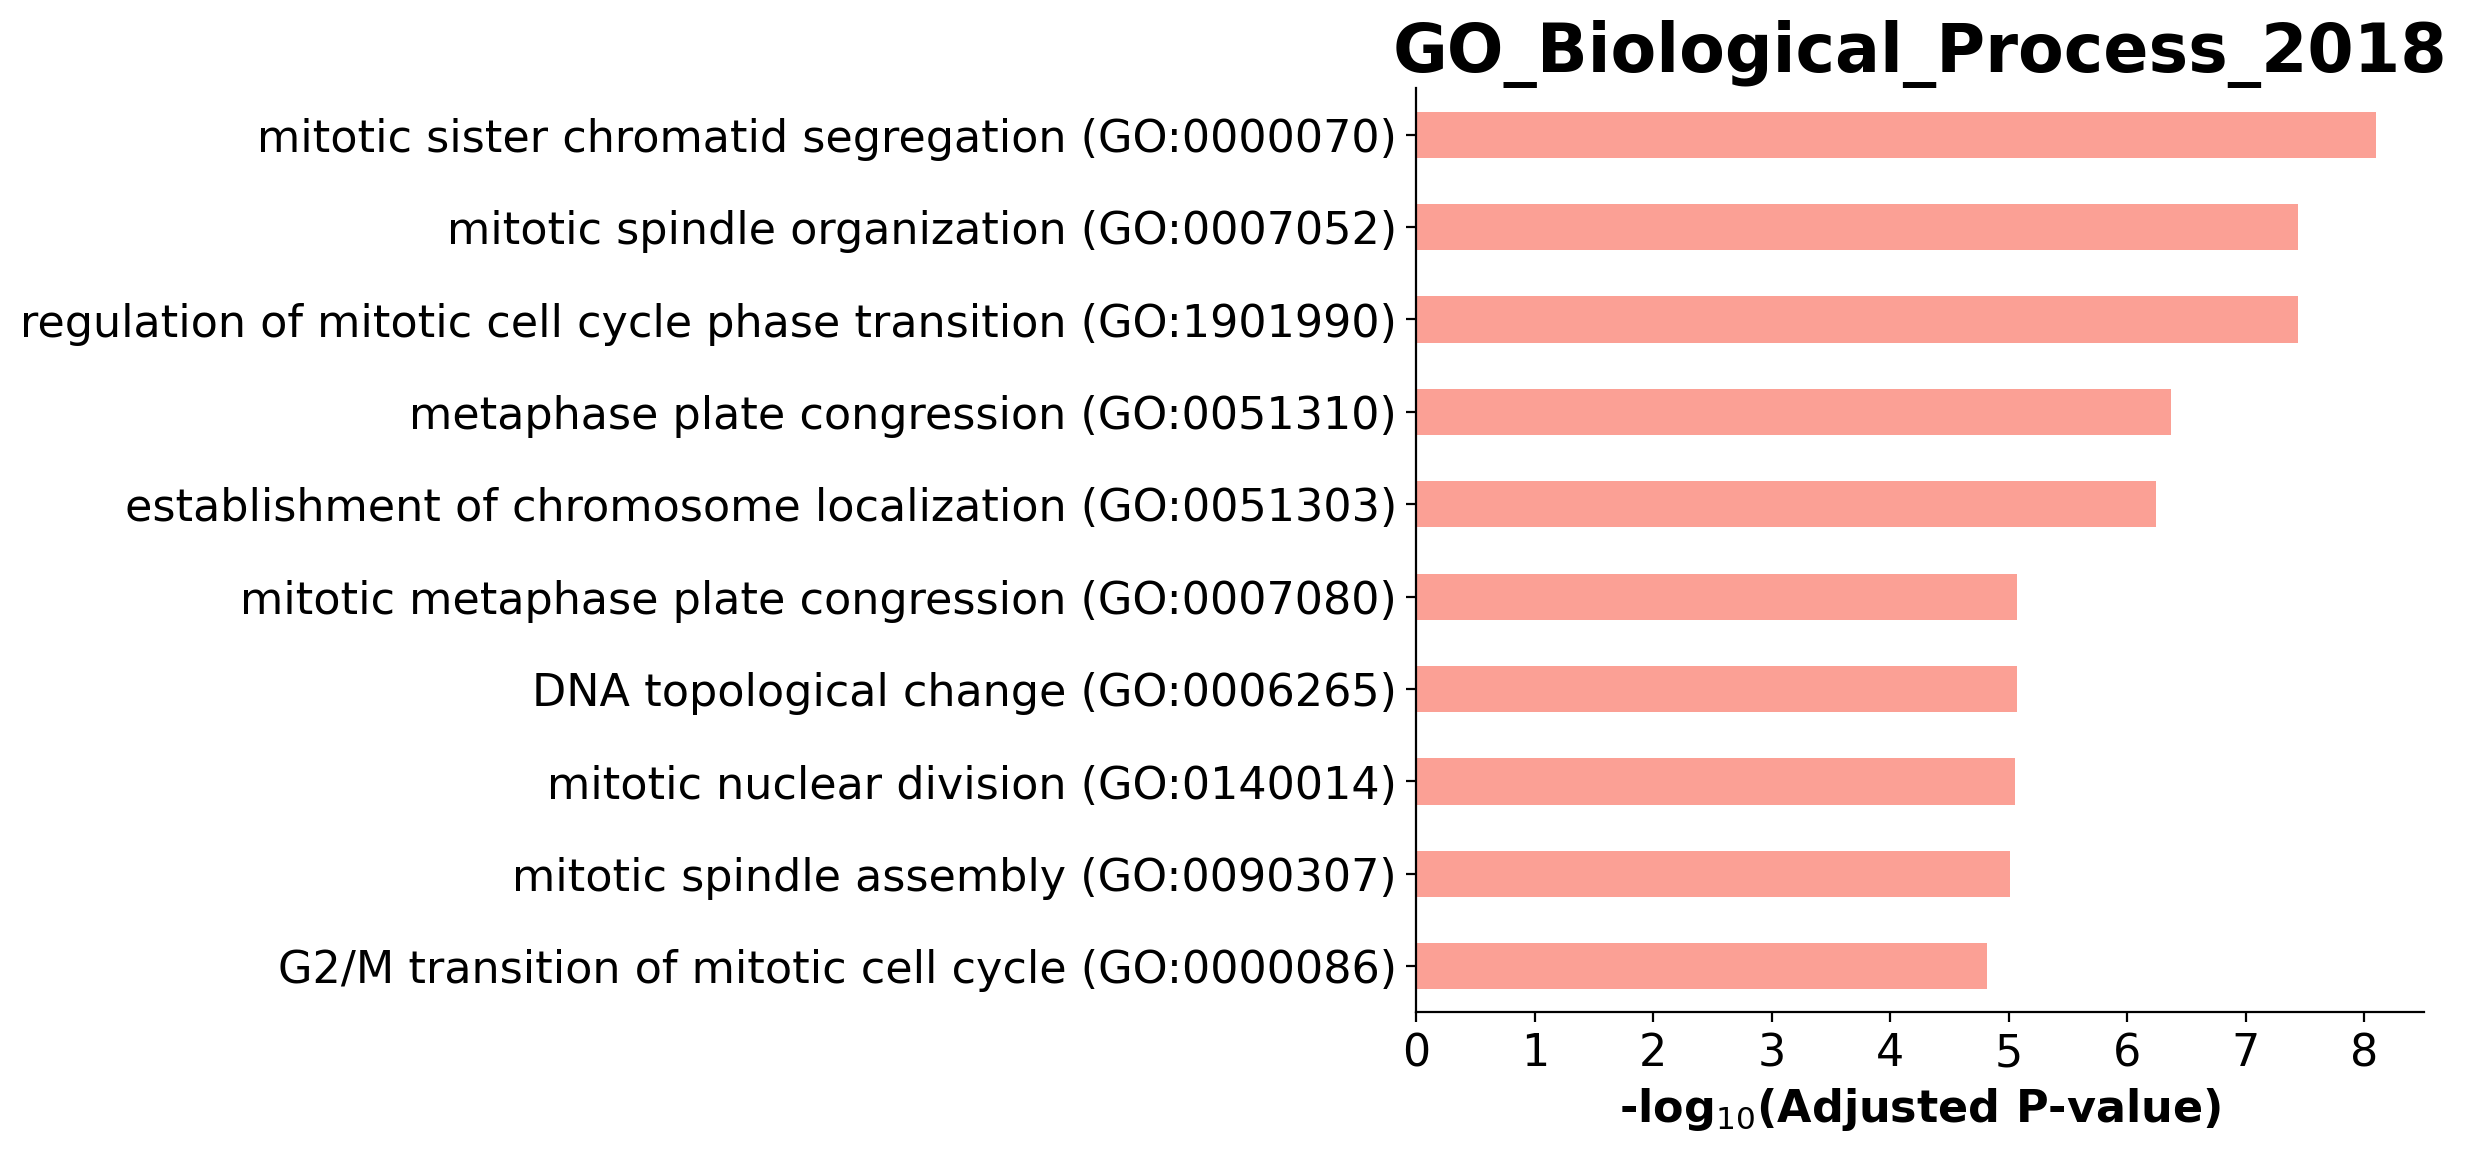

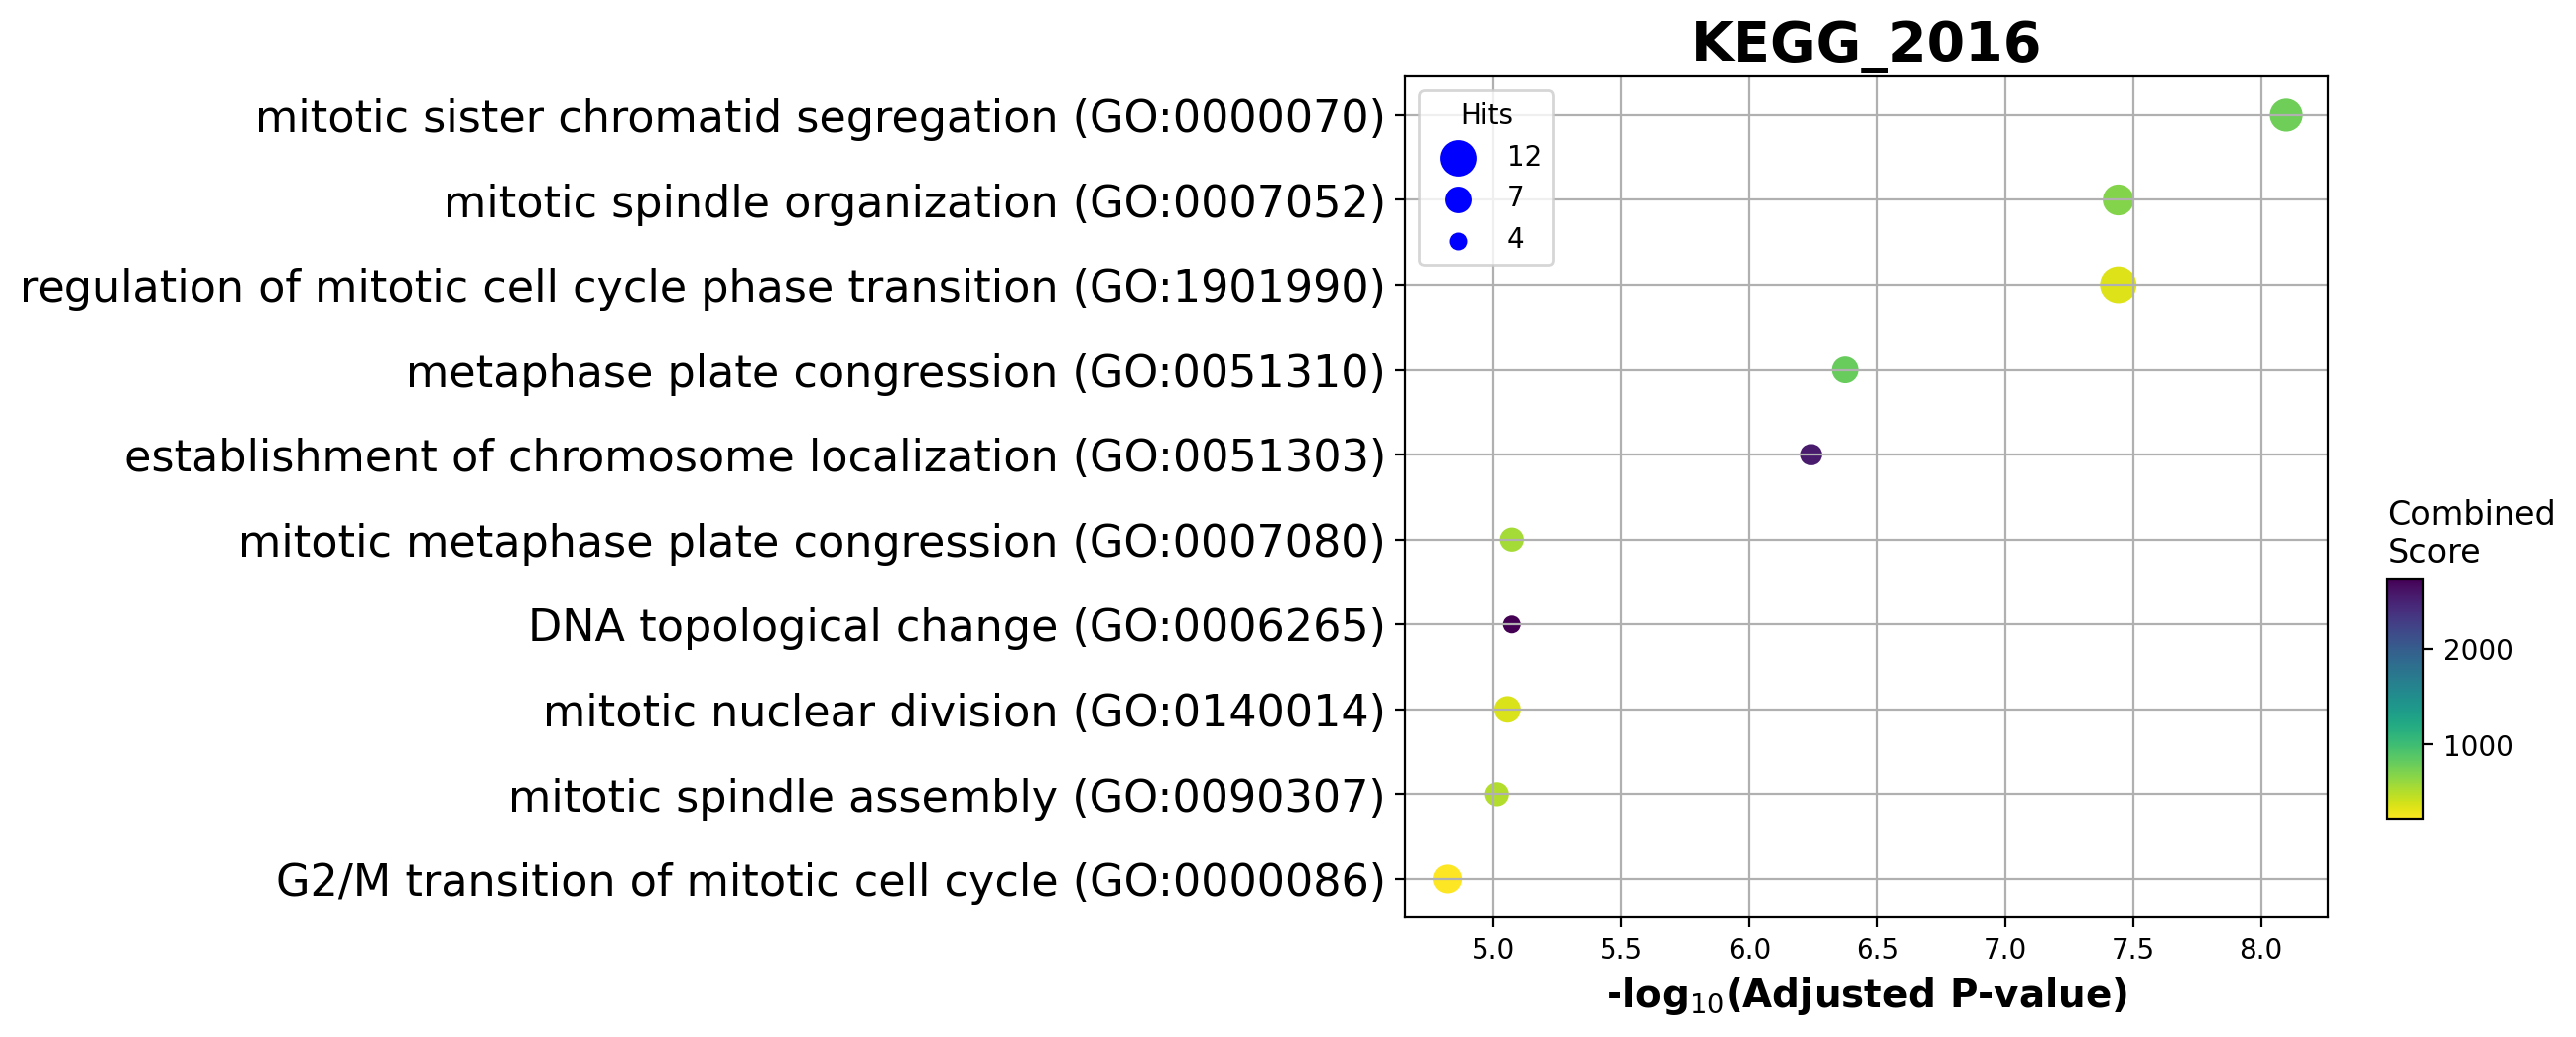

In [26]:
from gseapy.plot import barplot, dotplot
barplot(enr.res2d, title='GO_Biological_Process_2018', cutoff=0.05)
dotplot(enr.res2d, title='KEGG_2016',cmap='viridis_r', cutoff=0.05)

In [27]:
enr = dyn.ext.enrichr(adata.uns['rank_acceleration']['Ngn3 low EP'][:100].to_list(), organism='mouse', outdir='./enrichr')
enr.results.head(5)

2022-02-26 04:37:35,722 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


Gene_set  \
0  GO_Biological_Process_2018   
1  GO_Biological_Process_2018   
2  GO_Biological_Process_2018   
3  GO_Biological_Process_2018   
4  GO_Biological_Process_2018   

                                                Term Overlap   P-value  \
0  purine ribonucleotide metabolic process (GO:00...    4/66  0.000334   
1             oxoacid metabolic process (GO:0043436)    3/32  0.000541   
2                      bone development (GO:0060348)    3/34  0.000648   
3                          axonogenesis (GO:0007409)   6/223  0.000896   
4  regulation of protein dephosphorylation (GO:00...    3/40  0.001048   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.133671            0                     0   13.331989   
1          0.133671            0                     0   21.191966   
2          0.133671            0                     0   19.822747   
3          0.133671            0                     0    5.789685   
4          0.133671            0                     0   16.603232   

   Combined Score                                Genes  
0      106.701278             TPST2;SULT2B1;ACLY;HSPA8  
1      159.391414                  TPST2;SULT2B1;SULF2  
2      145.516274                      GNAS;PPIB;SULF2  
3       40.631271  VASP;LINGO1;LRRN2;TUBB3;MAP1B;GFRA3  
4      113.917477              PPP1R14A;PPP1R14B;CALM2